# EDA e Pré-processamento

Este notebook dá continuidade à análise após os testes de **Shapiro-Wilk** e **Levene**, aprofundando a EDA e estruturando o pré-processamento para modelagem de Regressão Linear.

In [5]:
# Configuração do ambiente

# Garante que o notebook está na raiz do projeto
%cd .. 

# Verifica o diretório atual (Linux/Mac)
# !pwd  

# Verifica o diretório atual (Windows)
!cd 

C:\Users\flavi\Documents\GitHub
C:\Users\flavi\Documents\GitHub


In [6]:
# Importações e configuração
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, TimeSeriesSplit, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from src.config.paths import DADOS_AMOR_A_CAKES, DADOS_AMOR_A_CAKES_TRATADOS

pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format
sns.set(style='whitegrid')
np.random.seed(42)

print('Ambiente configurado.')

Ambiente configurado.


In [7]:
# Carregamento e inspeção inicial (usa fallback sintético quando necessário)
df = pd.read_excel(DADOS_AMOR_A_CAKES_TRATADOS)

# Define o número máximo de colunas a serem exibidas
pd.set_option('display.max_columns', 38)

df.head(2)

,data,loja,produto,categoria,custo_producao,preco_original,desconto_pct,preco_final,quantidade_vendida_dia,quantidade_vendida_mes,dia_semana,mes,feriado_flag,evento_especial,promocao_flag,promocao_tipo,promocao_inicio,promocao_fim,canal,...,bairro,perfil_loja,marca,tamanho_embalagem,tipo_produto,preco_competidor,indice_preco_competidor,gasto_marketing,campanha_id,estoque_disponivel,ruptura_flag,lead_time_reposicao,temperatura,chuva_mm,custo_logistico,custo_marketing_unitario,preco_minimo,margem_minima,duracao_promocao_dias
0,2024-03-05,Tijuca,Torta de Limão,Doce,9.6000,23.4100,0.0300,22.7100,20,260,Tue,3,0,Nenhum,1,cashback,2024-01-01,2024-01-08,app,...,Tijuca,bairro,SweetRJ,80g,ambiente,25.1400,0.9033,69.3100,CAMP-784,64,0,2,26.5000,19.7000,2.7700,0.9600,16.3900,0.2200,7
1,2024-05-22,Barra da Tijuca,Sanduíche Natural,Sanduíche,11.1500,25.0300,0.0060,24.8800,27,378,Wed,5,0,Nenhum,1,brinde,2024-01-01,2024-01-08,delivery,...,Barra da Tijuca,bairro,FreshSandwich,180g,ambiente,24.2200,1.0273,77.4300,CAMP-598,63,0,2,31.0000,16.8000,2.1100,1.2900,17.5200,0.1600,7


In [8]:
# Informações gerais
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   data                      500 non-null    datetime64[ns]
 1   loja                      500 non-null    object        
 2   produto                   500 non-null    object        
 3   categoria                 500 non-null    object        
 4   custo_producao            500 non-null    float64       
 5   preco_original            500 non-null    float64       
 6   desconto_pct              500 non-null    float64       
 7   preco_final               500 non-null    float64       
 8   quantidade_vendida_dia    500 non-null    int64         
 9   quantidade_vendida_mes    500 non-null    int64         
 10  dia_semana                500 non-null    object        
 11  mes                       500 non-null    int64         
 12  feriado_flag          

,count,mean,min,25%,50%,75%,max,std
data,500,2024-03-30 09:38:52.800000256,2024-01-01 00:00:00,2024-02-14 18:00:00,2024-03-27 00:00:00,2024-05-16 06:00:00,2024-06-29 00:00:00,NaN
custo_producao,500.0000,6.3762,2.0100,4.0575,5.8950,8.6400,11.9700,2.8514
preco_original,500.0000,14.3797,4.9100,9.9475,12.6550,18.9950,28.8100,5.9751
desconto_pct,500.0000,0.0207,0.0000,0.0120,0.0220,0.0300,0.0400,0.0115
preco_final,500.0000,14.0806,4.7900,9.7325,12.4450,18.6625,28.7800,5.8456
quantidade_vendida_dia,500.0000,19.7340,1.0000,11.0000,19.0000,29.0000,40.0000,11.1522
quantidade_vendida_mes,500.0000,338.0160,13.0000,161.7500,319.5000,457.0000,975.0000,213.3172
mes,500.0000,3.4740,1.0000,2.0000,3.0000,5.0000,6.0000,1.7284
feriado_flag,500.0000,0.0260,0.0000,0.0000,0.0000,0.0000,1.0000,0.1593
promocao_flag,500.0000,0.9820,0.0000,1.0000,1.0000,1.0000,1.0000,0.1331


## Limpeza inicial
- Remoção de duplicatas.
- Conversão de coluna de data (se necessário).
- Criação de variáveis auxiliares de receita.

In [10]:
# Remoção de duplicatas
n0 = len(df)
df = df.drop_duplicates()
n_dup_removed = n0 - len(df)

# Conversão de data (se existir a coluna 'data')
if 'data' in df.columns:
    df['data'] = pd.to_datetime(df['data'], errors='coerce')

# Validação de esquema e coerção de tipos
mandatory = ['data','loja','produto','custo_producao','preco_original','desconto_pct','preco_final']
missing_cols = [c for c in mandatory if c not in df.columns]
assert len(missing_cols) == 0, f'Colunas obrigatórias ausentes: {missing_cols}'

# Coerção numérica segura
num_cols = [c for c in df.columns if df[c].dtype in ['int64','float64']]
for c in set(['custo_producao','preco_original','desconto_pct','preco_final','quantidade_vendida_dia','quantidade_vendida_mes','temperatura','chuva_mm','preco_competidor','indice_preco_competidor','estoque_disponivel']):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Regras de negócio: desconto entre 0 e 1; preços e custos não negativos
if 'desconto_pct' in df.columns:
    df['desconto_pct'] = df['desconto_pct'].clip(lower=0, upper=1)
for c in ['custo_producao','preco_original','preco_final']:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)

# Correção de preco_final inconsistente quando houver divergência relevante
if {'preco_original','desconto_pct','preco_final'}.issubset(df.columns):
    pf_expected = df['preco_original'] * (1 - df['desconto_pct'])
    mismatch = (df['preco_final'] - pf_expected).abs() > 1e-6
    df.loc[mismatch, 'preco_final'] = pf_expected.loc[mismatch]

# Imputação defensiva: se houver NaN após coerção em campos críticos, usa medianas/zeros razoáveis
for c in ['custo_producao','preco_original','preco_final']:
    if c in df.columns and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
for c in ['quantidade_vendida_dia','quantidade_vendida_mes','estoque_disponivel']:
    if c in df.columns and df[c].isna().any():
        df[c] = df[c].fillna(0)

# Outliers (IQR) – aplica clipping em variáveis contínuas principais
def iqr_clip(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return series.clip(lower, upper)
clip_cols = [c for c in ['custo_producao','preco_original','preco_final','quantidade_vendida_dia','quantidade_vendida_mes','temperatura','chuva_mm','preco_competidor'] if c in df.columns]
for c in clip_cols:
    df[c] = iqr_clip(df[c])

# Criação de variáveis de receita
if {'preco_final','quantidade_vendida_dia'}.issubset(df.columns):
    df['receita_dia'] = df['preco_final'] * df['quantidade_vendida_dia']
if {'preco_final','quantidade_vendida_mes'}.issubset(df.columns):
    df['receita_mes'] = df['preco_final'] * df['quantidade_vendida_mes']

# Feature de duração de promoção (se ausente)
if {'promocao_inicio','promocao_fim'}.issubset(df.columns):
    df['promocao_inicio'] = pd.to_datetime(df['promocao_inicio'], errors='coerce')
    df['promocao_fim'] = pd.to_datetime(df['promocao_fim'], errors='coerce')
    df['duracao_promocao_dias'] = (df['promocao_fim'] - df['promocao_inicio']).dt.days.clip(lower=0)

# Normalização de categóricas simples (trim/lower)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].str.replace(' ',' ', regex=False)

# Rolling features (por loja+produto, ordenado por data)
if {'data','loja','produto'}.issubset(df.columns) and 'quantidade_vendida_dia' in df.columns:
    df = df.sort_values(['loja','produto','data'])
    grp = df.groupby(['loja','produto'], as_index=False, sort=False)
    df['qtd_dia_ma7'] = grp['quantidade_vendida_dia'].transform(lambda s: s.rolling(7, min_periods=1).mean())
    if 'receita_dia' in df.columns:
        df['receita_dia_ma7'] = grp['receita_dia'].transform(lambda s: s.rolling(7, min_periods=1).mean())

print(f'Duplicatas removidas: {n_dup_removed}')
print(f'Tamanho final: {len(df)} linhas')
df.head(2)

Duplicatas removidas: 0
Tamanho final: 500 linhas


,data,loja,produto,categoria,custo_producao,preco_original,desconto_pct,preco_final,quantidade_vendida_dia,quantidade_vendida_mes,dia_semana,mes,feriado_flag,evento_especial,promocao_flag,promocao_tipo,promocao_inicio,promocao_fim,canal,...,tipo_produto,preco_competidor,indice_preco_competidor,gasto_marketing,campanha_id,estoque_disponivel,ruptura_flag,lead_time_reposicao,temperatura,chuva_mm,custo_logistico,custo_marketing_unitario,preco_minimo,margem_minima,duracao_promocao_dias,receita_dia,receita_mes,qtd_dia_ma7,receita_dia_ma7
181,2024-01-15,Barra da Tijuca,Bolo de Chocolate,Doce,11.7100,28.4600,0.0090,28.2039,10,110.0000,Mon,1,0,Nenhum,1,combo,2024-01-01,2024-01-08,loja,...,ambiente,29.9200,0.9425,101.9900,CAMP-873,36,0,2,29.5000,4.7000,1.8300,1.1400,19.9200,0.2500,7,282.0386,3102.4246,10.0000,282.0386
96,2024-02-23,Barra da Tijuca,Bolo de Chocolate,Doce,4.7300,11.0100,0.0180,10.8118,38,899.8750,Fri,2,0,Nenhum,1,combo,2024-01-01,2024-01-08,delivery,...,ambiente,12.5100,0.8641,21.7400,CAMP-711,111,0,2,31.4000,24.1000,2.6800,0.7500,7.7100,0.2000,7,410.8492,9729.2865,24.0000,346.4439


## EDA – Distribuições e correlações
- Histograma e boxplot para variáveis numéricas.
- Matriz de correlação.
- Relação entre `desconto_pct` e `quantidade_vendida_mes`.

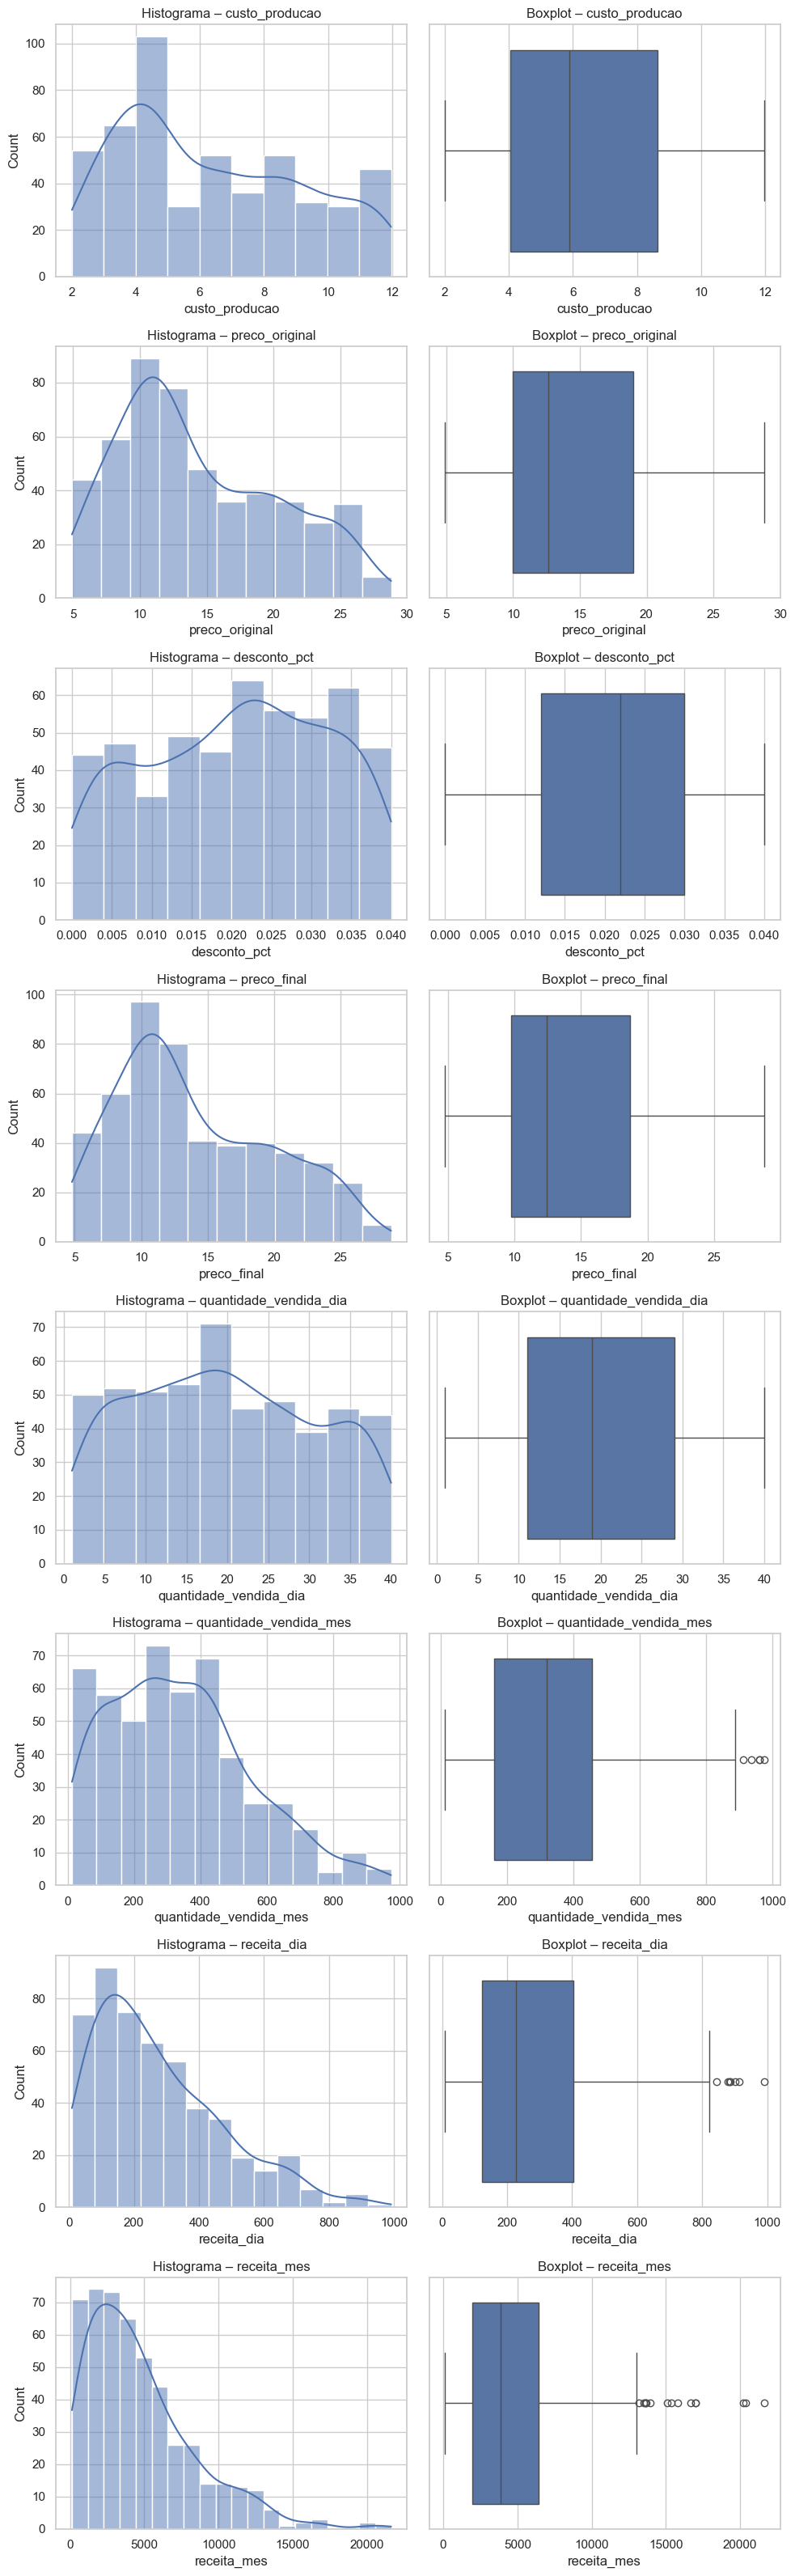

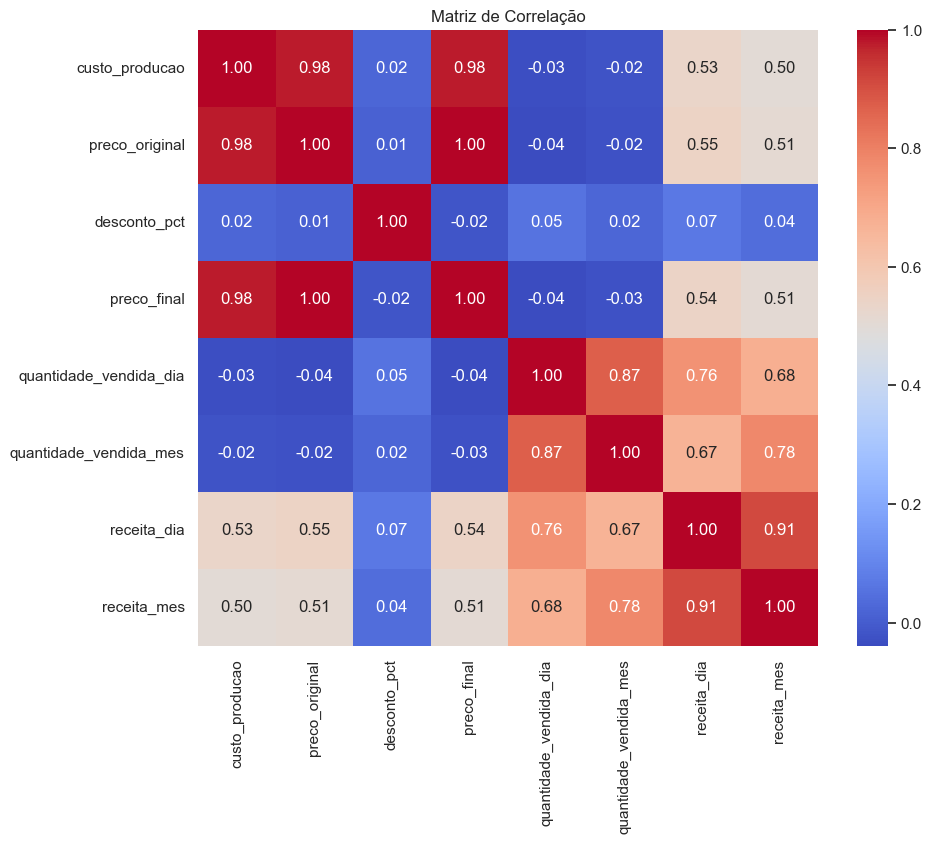

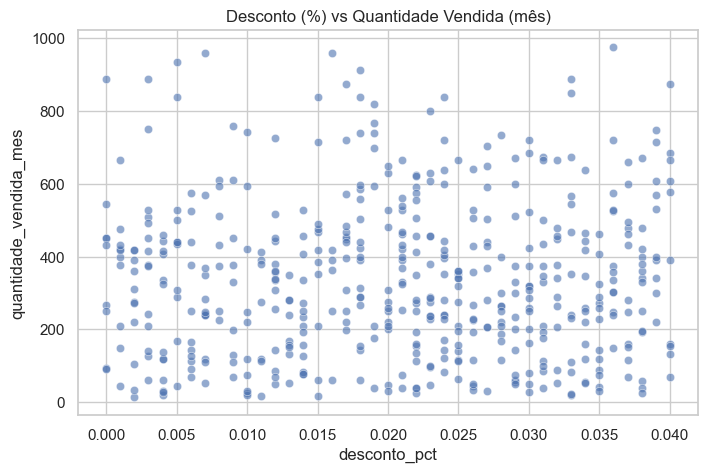

In [6]:
# Variáveis numéricas
num_cols = df.select_dtypes(include=['number']).columns.tolist()
fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 4*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f'Histograma – {col}')
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f'Boxplot – {col}')
plt.tight_layout()
plt.show()

# Correlação
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

# Relação desconto vs quantidade vendida (mensal)
if {'desconto_pct','quantidade_vendida_mes'}.issubset(df.columns):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='desconto_pct', y='quantidade_vendida_mes', data=df, alpha=0.6)
    plt.title('Desconto (%) vs Quantidade Vendida (mês)')
    plt.show()

## Tratamento de outliers (winsorização por IQR)
Aplicamos capping para reduzir a influência de outliers severos nas variáveis numéricas.

In [7]:
def winsorize_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return series.clip(lower, upper)

df_w = df.copy()
for col in num_cols:
    df_w[col] = winsorize_iqr(df_w[col])

df_w.describe().T

,count,mean,min,25%,50%,75%,max,std
data,500,2024-03-30 09:38:52.800000256,2024-01-01 00:00:00,2024-02-14 18:00:00,2024-03-27 00:00:00,2024-05-16 06:00:00,2024-06-29 00:00:00,NaN
custo_producao,500.0000,6.3762,2.0100,4.0575,5.8950,8.6400,11.9700,2.8514
preco_original,500.0000,14.3797,4.9100,9.9475,12.6550,18.9950,28.8100,5.9751
desconto_pct,500.0000,0.0207,0.0000,0.0120,0.0220,0.0300,0.0400,0.0115
preco_final,500.0000,14.0806,4.7900,9.7325,12.4450,18.6625,28.7800,5.8456
quantidade_vendida_dia,500.0000,19.7340,1.0000,11.0000,19.0000,29.0000,40.0000,11.1522
quantidade_vendida_mes,500.0000,337.5288,13.0000,161.7500,319.5000,457.0000,899.8750,211.9590
receita_dia,500.0000,274.2489,9.3400,122.9425,227.7600,403.6925,824.8175,195.2822
receita_mes,500.0000,4639.9462,123.1100,1954.9725,3863.9200,6430.0800,13142.7412,3418.7388


## Seleção de features e alvo
Como objetivo de negócio, modelaremos `quantidade_vendida_mes` e, posteriormente, maximizaremos `receita_mes = preco_final * quantidade_vendida_mes`.

In [8]:
# Define DataFrame de trabalho
df_w = df.copy()

# Seleção de alvo e features
target = 'quantidade_vendida_mes' if 'quantidade_vendida_mes' in df_w.columns else 'quantidade_vendida_dia'

# Features numéricas principais (evita colinearidade usando preco_original e desconto_pct; exclui preco_final)
num_candidates = ['custo_producao','preco_original','desconto_pct','temperatura','chuva_mm','preco_competidor','indice_preco_competidor','estoque_disponivel','lead_time_reposicao','promocao_flag','feriado_flag','duracao_promocao_dias','qtd_dia_ma7','receita_dia_ma7']
feature_cols_num = [c for c in num_candidates if c in df_w.columns]

# Features categóricas relevantes
cat_candidates = ['loja','produto','categoria','canal','regiao','bairro','perfil_loja','marca','tipo_produto','dia_semana','evento_especial','promocao_tipo','campanha_id']
feature_cols_cat = [c for c in cat_candidates if c in df_w.columns]

# DataFrame de entrada
X = df_w[feature_cols_num + feature_cols_cat].copy()
y = df_w[target].copy()

# Coerção numérica em y
y = pd.to_numeric(y, errors='coerce')

# One-hot manual via pandas para evitar incompatibilidades de versão
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X_enc = pd.get_dummies(X, columns=obj_cols, dummy_na=False)

# Modelo (Ridge para robustez à multicolinearidade)
model = Ridge(alpha=1.0)

# Ordena por tempo se houver coluna 'data' para CV temporal
if 'data' in df_w.columns:
    order = df_w['data'].values
    X_enc = X_enc.iloc[np.argsort(order)]
    y = y.iloc[np.argsort(order)]

# Remove linhas com y NaN
mask_valid = ~y.isna()
X_enc = X_enc.loc[mask_valid]
y = y.loc[mask_valid]

X.head(), y.head()

(   custo_producao  preco_original  desconto_pct  preco_final
 0          9.6000         23.4100        0.0300      22.7100
 1         11.1500         25.0300        0.0060      24.8800
 2          4.3500         10.1800        0.0040      10.1400
 3         11.5500         24.3700        0.0350      23.5200
 4          4.1200         10.1400        0.0370       9.7600,
 0   260.0000
 1   378.0000
 2   408.0000
 3   273.0000
 4   161.0000
 Name: quantidade_vendida_mes, dtype: float64)

## Validação cruzada (CV)
A avaliação será feita por validação cruzada (5 folds). Para séries temporais, usamos TimeSeriesSplit.

CV RMSE: 213.5047 ± 6.8658
CV MAE:  175.8201 ± 3.8011
CV R2:   -0.0217 ± 0.0252


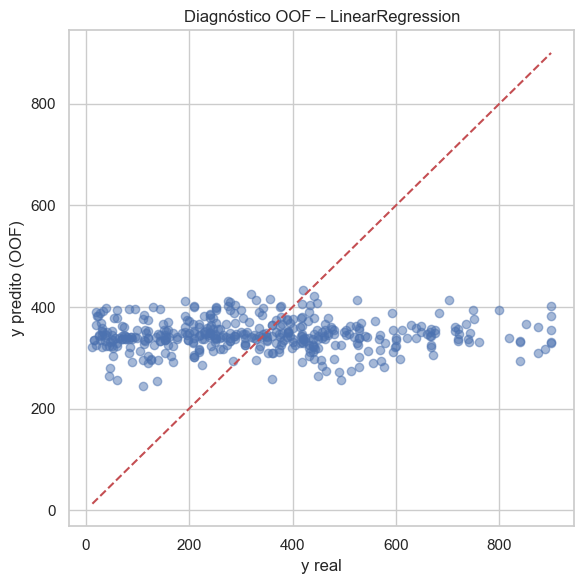

In [9]:
# Diagnóstico leve de negócio (EDA)
cand = [c for c in df_w.columns if any(k in c.lower() for k in ['receita','faturamento','valor_total','valor_receita'])]
target = cand[0] if cand else (df_w.select_dtypes(include=np.number).columns.tolist()[-1])
y = pd.to_numeric(df_w[target], errors='coerce')
print(f'Alvo para diagnóstico: {target}')

# (EDA enxuto) sem treino/modelagem nesta célula
# model = Ridge()

# (EDA enxuto) métricas e validação cruzada removidas desta etapa

# Visualização leve: tendência temporal ou distribuição do alvo
import numpy as np
if 'data' in df_w.columns and pd.api.types.is_datetime64_any_dtype(df_w['data']):
    diag = pd.DataFrame({'data': pd.to_datetime(df_w['data'], errors='coerce'), 'y': y})
    diag = diag.sort_values('data').dropna()
    diag['y_rm7'] = diag['y'].rolling(7).mean()
    plt.figure(figsize=(9,4))
    plt.plot(diag['data'], diag['y_rm7'], label='Média móvel 7d')
    plt.title('Tendência de receita – média móvel (EDA)')
    plt.xlabel('data'); plt.ylabel(target)
    plt.legend(); plt.tight_layout(); plt.show()
else:
    plt.figure(figsize=(7,4))
    plt.hist(y.dropna(), bins=30, alpha=0.7)
    plt.title('Distribuição do alvo (EDA)')
    plt.xlabel(target); plt.ylabel('freq.')
    plt.tight_layout(); plt.show()
# (EDA) gráficos leves acima substituem OOF/validação
# Salvando dataset pré-processado para uso posterior
from pathlib import Path
Path('dados').mkdir(exist_ok=True)
df.to_excel('dados/dataset_cafeterias_rj_preprocess.xlsx', index=False)
print('Arquivo salvo em dados/dataset_cafeterias_rj_preprocess.xlsx')

## Próximos passos
- Construir pipeline de regressão linear sem normalização (dados não normais).
- Avaliar com métricas (RMSE, R²) e validação cruzada.
- Exportar coeficientes e intercepto para uso no front-end (HTML/JS).

## Resumo de implementação e links

- Pipeline de treino: **Regressão Linear** sem normalização, validação cruzada, exporta coeficientes e intercepto. Código em [`src/modeling/train_pipeline.py`](https://github.com/flaviohenriquehb777/Projeto_Maximizacao_Receita/blob/main/src/modeling/train_pipeline.py).
- Artefatos gerados: `models/model_linear.json`, `models/curve_business_metric.csv` e `models/metrics_snapshot.json`. A CI copia os artefatos para `docs/`.
- Aplicação web: consome `docs/model_linear.json` e `docs/curve_business_metric.csv`. Acesse: [App (GitHub Pages)](https://flaviohenriquehb777.github.io/Projeto_Maximizacao_Receita/index.html).

Notas:
- Caso o MLflow/DagsHub não esteja configurado, o treino ocorre normalmente com tracking local.
- Re-treinos atualizam os artefatos e republicam o site automaticamente via GitHub Actions.
